In [6]:
import numpy as np
import scipy.linalg as  la
%matplotlib inline
import matplotlib.pyplot as plt
import time
import hamiltonian as hm
import importlib
import scipy.special

In [156]:
def chop(a):
    if not np.all(np.isclose(np.imag(a),0)): 
        print("\nchop() removed the imaginary part\n ")
    A = np.round(np.real(a),3)
    if np.all(np.isclose(A.astype(int), A)): return A.astype(int)
    else: return A

In [4]:
def norm(A):
    norm = np.trace(A @ A.T.conj())/(len(A))
    assert np.isclose(np.imag(norm),0)
    return np.real(norm)

In [5]:
def tensor(*args):
    A = 1
    for arg in args:
        A = np.kron(A, arg)
    return A

In [6]:
def par_tr(x,i):
    N = len(x)
    assert 2**i < N
    
    indices = np.array(range(N))
    bit = int((N/2)/2**i)
    mask = N - (bit) - 1
    indices = indices & mask
    return (x[:,np.unique(indices)][np.unique(indices)] + 
            x[:,np.unique(indices + bit)][np.unique(indices + bit)])/2

In [144]:
# Trace out the last/first i spins
def end_trace(x, i):
    N = len(x)
    untraced = (int) (N/2**i)
    traced = 2**i
    x = x.reshape((untraced, traced, untraced, traced))
    return np.trace(x, axis1=1, axis2=3)/2**i
def front_trace(x, i):
    N = len(x)
    untraced = (int) (N/2**i)
    traced = 2**i
    x = x.reshape((traced, untraced, traced, untraced))
    return np.trace(x, axis1=0, axis2=2)/2**i

In [8]:
def sparse_Hmult(l):
    if (l==3): return H3mult
#     print(np.shape(np.kron(sparse_Hmult(l-2),I2)))
#     print(np.shape(np.kron(np.eye(l-3), H3mult)))
    return np.kron(sparse_Hmult(l-2),I2) + np.kron(np.eye(2**(l-3)), H3mult)

def sparse_ham(l):
    if (l%2 != 1): assert False, "l must be odd"
    H = sparse_Hmult(l)
    return H * (2j * np.pi)/(3 * np.sqrt(3))

In [157]:
def block_diagonalize(matrix):
    A = []
    j = 0
    for i in range(L+1):
        k = j + (int) (scipy.special.comb(l,i))
        A.append(matrix[j:k, j:k])
        j = k
    return A

# 3-Site system

In [17]:
H3mult = np.array([[0 ,  0 ,  0 ,  0 ,  0 ,  0 ,  0 , 0],
               [0 ,  0 ,  1 ,  0 , -1 ,  0 ,  0 , 0],
               [0 , -1 ,  0 ,  0 ,  1 ,  0 ,  0 , 0],
               [0 ,  0 ,  0 ,  0 ,  0 , -1 ,  1 , 0],
               [0 ,  1 , -1 ,  0 ,  0 ,  0 ,  0 , 0],
               [0 ,  0 ,  0 ,  1 ,  0 ,  0 , -1 , 0],
               [0 ,  0 ,  0 , -1 ,  0 ,  1 ,  0 , 0],
               [0 ,  0 ,  0 ,  0 ,  0 ,  0 ,  0 , 0]])
H3 = H3mult * (2j * np.pi)/(3 * np.sqrt(3))

I = np.array([[ 1,  0],[ 0,  1]])
X = np.array([[ 0,  1],[ 1,  0]])
Y = np.array([[ 0,-1j],[1j,  0]])
Z = np.array([[ 1,  0],[ 0, -1]])

I2 = np.kron(I,I)

In [8]:
vals, vecs = la.eigh(H3)
eners = np.diag(vals)
vecsd = vecs.T.conj()

In [9]:
print(np.all(np.isclose(vecs@eners@vecsd, H3)))

True


In [10]:
unit3t = vecs@np.diag(np.exp(-1j*vals))@vecsd
print(chop(unit3t))

[[1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1]]


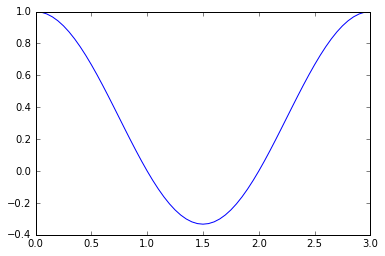

In [11]:
end = 3
n = 20
N = n*end
first = np.empty(N)
second = np.empty(N)
third = np.empty(N)

for i in np.arange(N):
    t = i/n
    unit3t = vecs@np.diag(np.exp(-1j*vals*t))@vecsd
    first[i] = np.real(unit3t[1,1])
    second[i] = np.real(unit3t[4,1])
    third[i] = np.real(unit3t[2,1])
#     print(t)

plt.plot(np.arange(N)/n, first)
plt.show()
# print(first)

### 3-Site Tsunami
##### Make gate, evolve in time, trace out different spins, rinse, repeat

In [12]:
# Total time elapsed
end = 3
# Time steps per second
n = 6
N = n*end
A = np.kron(np.kron(Z,I),I)

weight0 = np.empty(N)
weight1 = np.empty(N)
weight2 = np.empty(N)

for i in np.arange(N):
    t = i/n
    unit3t = vecs@np.diag(np.exp(-1j*vals*t))@vecsd
    At = np.linalg.inv(unit3t) @ A @ unit3t
#     print(chop(unit3t),"\n")
    
    weight0[i] = 1 - norm(par_tr(At,0))
    weight1[i] = 1 - norm(par_tr(At,1))
    weight2[i] = 1 - norm(par_tr(At,2))

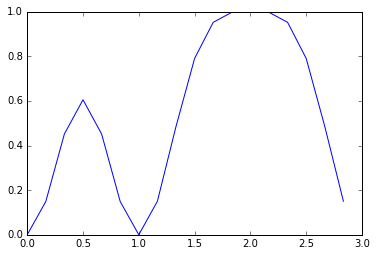

In [13]:
plt.plot(np.arange(N)/n,weight1)
plt.show()

# 5-Site

In [18]:
H5mult = np.kron(H3mult,np.kron(I,I)) + np.kron(np.kron(I,I),H3mult)
H5 = H5mult * (2j * np.pi)/(3 * np.sqrt(3))

In [19]:
vals5, vecs5 = la.eigh(H5)
eners5 = np.diag(vals5)
vecsd5 = vecs5.T.conj()

In [20]:
unit5 = vecs5@np.diag(np.exp(-1j*vals5))@vecsd5
print(chop(unit5[:10,:10]))

[[ 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.105  0.944 -0.     0.192  0.    -0.     0.    -0.249  0.   ]
 [ 0.    -0.181  0.105  0.     0.571  0.    -0.     0.     0.754  0.   ]
 [ 0.     0.    -0.     0.202  0.     0.109  0.64   0.     0.    -0.386]
 [ 0.     0.571  0.192  0.    -0.525  0.    -0.     0.     0.571  0.   ]
 [ 0.     0.     0.     0.64   0.    -0.463  0.04   0.     0.     0.294]
 [ 0.    -0.    -0.     0.109 -0.     0.359 -0.463  0.    -0.     0.277]
 [ 0.     0.     0.    -0.     0.     0.     0.     0.202  0.     0.   ]
 [ 0.    -0.249  0.008  0.     0.192  0.    -0.     0.     0.105  0.   ]
 [ 0.     0.     0.    -0.195  0.     0.106  0.086 -0.     0.    -0.253]]


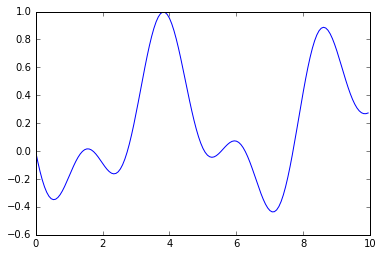

In [21]:
end = 10
n = 15
N = n*end
first = np.empty(N)
second = np.empty(N)
third = np.empty(N)

for i in np.arange(N):
    t = i/n
    unit5t = vecs5@np.diag(np.exp(-1j*vals5*t))@vecsd5
    first[i] = np.real(unit5t[1,1])
    second[i] = np.real(unit5t[4,1])
    third[i] = np.real(unit5t[2,1])
#     print(t)

plt.plot(np.arange(N)/n, third)
plt.show()
# print(first)

### 5-Site Tsunami
##### Make gate, evolve in time, trace out different spins, rinse, repeat

In [151]:
# Total time elapsed
end = 2
# Time steps per second
n = 20
N = n*end
A5 = np.kron(np.kron(Z,I),np.kron(np.kron(I,I),I))
B5 = np.kron(np.kron(I,I),np.kron(np.kron(I,I),Z))

weightfore = np.empty((5, N))
weightback = np.empty((5, N))

for i in np.arange(N):
    t = i/n
    unit5t = vecs5@np.diag(np.exp(-1j*vals5*t))@vecsd5
    A5t = np.linalg.inv(unit5t) @ A5 @ unit5t
    B5t = np.linalg.inv(unit5t) @ B5 @ unit5t
#     print(chop(unit3t),"\n")
    front = norm(A5t)
    back  = norm(B5t)
    
    for j in range(5):
#         A5t = par_tr(A5t,5-j-1)
        A5t = end_trace(A5t,1)
        B5t = front_trace(B5t,1)
        fronthere = norm(A5t)
        backhere  = norm(B5t)
        weightfore[5-1-j,i] = front - fronthere
        weightback[j,i]     = back  - backhere
        front = fronthere
        back  = backhere

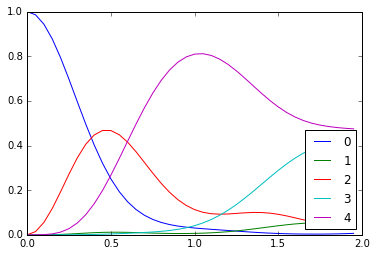

In [152]:
for i in range(5):
    plt.plot(np.arange(N)/n,weightfore[i], label = str(i))
plt.legend(loc=4)
plt.show()

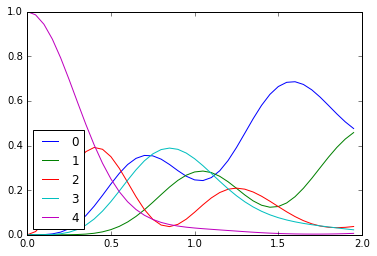

In [153]:
for i in range(5):
    plt.plot(np.arange(N)/n,weightback[i], label = str(i))
plt.legend(loc=3)
plt.show()

# Saving to File

In [31]:
L = 9

H = hm.sparse_H(L)
vals, vecs = la.eigh(H)
eners = np.diag(vals)
vecsd = vecs.T.conj()

# Total time elapsed
end = 3
# Time steps per second
n = 20
N = n*end
A = hm.Z
for i in range(L-1):
    A = np.kron(A,hm.I)
B = hm.Z
for i in range(L-1):
    B = np.kron(hm.I,B)

weightfore9 = np.empty((L, N))
weightback9 = np.empty((L, N))

for i in np.arange(N):
    t = i/n
    unitt = np.matmul(np.matmul(vecs,  np.diag(np.exp(-1j*vals*t))), vecsd)
    uninv = np.matmul(np.matmul(vecs,  np.diag(np.exp( 1j*vals*t))), vecsd)
    At    = np.matmul(np.matmul(uninv, A),             unitt)
    Bt    = np.matmul(np.matmul(uninv, B),             unitt)
#     At    = np.matmul(np.matmul(np.linalg.inv(unitt), A),             unitt)
#     Bt    = np.matmul(np.matmul(np.linalg.inv(unitt), B),             unitt)
#     print(chop(unit3t),"\n")
    front = hm.norm(At)
    back  = hm.norm(Bt)
    
    for j in range(L):
        At = hm.end_trace(At,1)
        Bt = hm.front_trace(Bt,1)
        fronthere = hm.norm(At)
        backhere  = hm.norm(Bt)
        weightfore9[L-1-j, i] = front - fronthere
        weightback9[j, i]     = back  - backhere
        front = fronthere
        back  = backhere

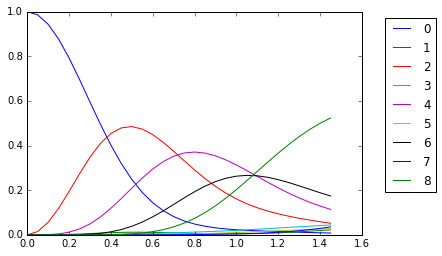

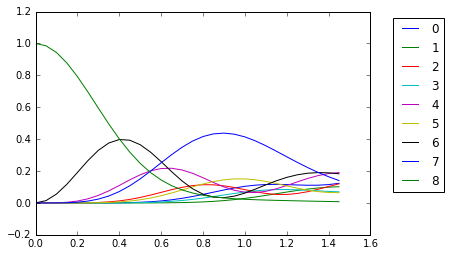

In [34]:
end = (int) (n*1.5)

for i in range(L):
    plt.plot(np.arange(end)/n,weightfore9[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylim(0,1)
plt.show()

for i in range(L):
    plt.plot(np.arange(end)/n,weightback9[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

# Basis Permutation
### Alphabetic <-> Constant $S_Z$ bases

In [47]:
def permutations(L):
    alph2Sz = np.zeros(2**L, dtype=int)
    for i in range(2**L):
        alph2Sz[i] = bin(i).count('1')
    alph2Sz = alph2Sz.argsort()
    Sz2alph = np.zeros(2**L, dtype=int)
    for idx, val in enumerate(alph2Sz):
        Sz2alph[val] = idx
    return alph2Sz, Sz2alph

def mat2list(matrix):
    L = (int) (np.log2(len(matrix)))
    alph2Sz, Sz2alph = permutations(L)
    diag = matrix[alph2Sz]
    diag = diag[:,alph2Sz]
    A = []
    j = 0
    for i in range(L+1):
        k = j + (int) (scipy.special.comb(L,i))
        A.append(diag[j:k, j:k])
        j = k
    return A

def list2mat(A):
    L = len(A) - 1
    alph2Sz, Sz2alph = permutations(L)
    diag = la.block_diag(*A)
    mat = diag[Sz2alph]
    return mat[:,Sz2alph]

In [24]:
importlib.reload(hm)

<module 'hamiltonian' from '/Users/cstahl/Documents/Senior/Thesis/python/Hamiltonian/hamiltonian.py'>

True


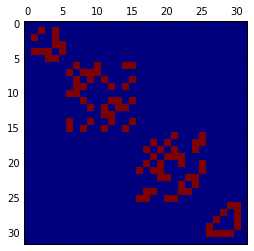

In [50]:
L = 5
H = hm.sparse_H(L)

alph2Sz, Sz2alph = permutations(L)
# print(alph2Sz)

# plt.matshow(np.imag(H))
# plt.show()
# Hdiag = H[alph2Sz]
# Hdiag = Hdiag[:,alph2Sz]
# plt.matshow(np.imag(Hdiag))
# plt.show()

A = mat2list(H)
# for M in A:
#     plt.matshow(np.absolute(M))
#     plt.show()
# Hdiag2 = la.block_diag(*A)
# plt.matshow(np.imag(Hdiag2))
# plt.show()

# H2 = Hdiag2[Sz2alph]
# H2 = H2[:,Sz2alph]
H2 = list2mat(A)

print(np.all(np.isclose(H,H2)))

vals, vecs = la.eigh(H)
eners = np.diag(vals)
vecsd = vecs.T.conj()
M = vecs * vals @ vecsd

M = M[alph2Sz]
M = M[:,alph2Sz]
plt.matshow(np.absolute(M))
plt.show()

In [23]:
%run -p permute.py

### Including block diagonalization

In [3]:
L = 9

H = hm.sparse_H(L)
vals, vecs = la.eigh(H)
vecsd = vecs.T.conj()

# Total time elapsed
end = 3
# Time steps per second
n = 20
N = n*end
A = hm.Z
for i in range(L-1):
    A = np.kron(A,hm.I)
Alist = hm.mat2list(A)
B = hm.Z
for i in range(L-1):
    B = np.kron(hm.I,B)
Blist = hm.mat2list(B)


weightfore9 = np.empty((L, N))
weightback9 = np.empty((L, N))

for i in np.arange(N):
    t = i/n
    unitt = np.matmul(vecs * np.exp(-1j*vals*t), vecsd)
    uninv = np.matmul(vecs * np.exp( 1j*vals*t), vecsd)
    
    ulist = hm.mat2list(unitt)
    uinvlist = hm.mat2list(uninv)
    
    Atlist = []
    for idx, val in enumerate(Alist):
        Atlist.append(np.matmul(np.matmul(uinvlist[idx], val), ulist[idx]))
    Btlist = []
    for idx, val in enumerate(Blist):
        Btlist.append(np.matmul(np.matmul(uinvlist[idx], val), ulist[idx]))
    At = hm.list2mat(Atlist)
    Bt = hm.list2mat(Btlist)
    
    front = hm.norm(At)
    back  = hm.norm(Bt)
    
    for j in range(L):
        At = hm.end_trace(At,1)
        Bt = hm.front_trace(Bt,1)
        fronthere = hm.norm(At)
        backhere  = hm.norm(Bt)
        weightfore9[L-1-j, i] = front - fronthere
        weightback9[j, i]     = back  - backhere
        front = fronthere
        back  = backhere

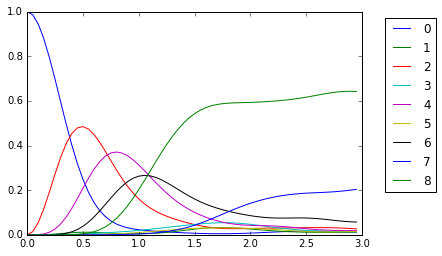

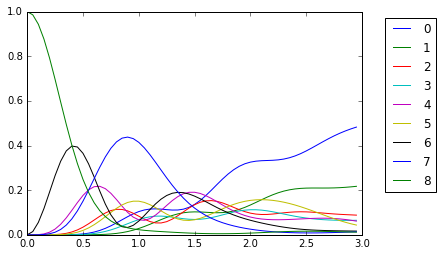

In [4]:
end = (int) (n*3)

for i in range(L):
    plt.plot(np.arange(end)/n,weightfore9[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylim(0,1)
plt.show()

for i in range(L):
    plt.plot(np.arange(end)/n,weightback9[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylim(0,1)
plt.show()

### ...and keeping A, B as lists of arrays

In [7]:
L = 9

H = hm.sparse_H(L)
vals, vecs = la.eigh(H)
vecsd = vecs.T.conj()

# Total time elapsed
end = 3
# Time steps per second
n = 20
N = n*end
A = np.array([hm.Z[0,0], hm.Z[1,1]])
for i in range(L-1):
    A = np.kron(A,np.array([1,1]))
Alist = hm.arr2list(A)
B = np.array([hm.Z[0,0], hm.Z[1,1]])
for i in range(L-1):
    B = np.kron(np.array([1,1]),B)
Blist = hm.arr2list(B)


weightfore9 = np.empty((L, N))
weightback9 = np.empty((L, N))

for i in np.arange(N):
    t = i/n
    unitt = np.matmul(vecs * np.exp(-1j*vals*t), vecsd)
    uninv = np.matmul(vecs * np.exp( 1j*vals*t), vecsd)
    
    ulist = hm.mat2list(unitt)
    uinvlist = hm.mat2list(uninv)
    
    Atlist = []
    for idx, val in enumerate(Alist):
        Atlist.append(np.matmul(uinvlist[idx] * val, ulist[idx]))
    Btlist = []
    for idx, val in enumerate(Blist):
        Btlist.append(np.matmul(uinvlist[idx] * val, ulist[idx]))
    At = hm.list2mat(Atlist)
    Bt = hm.list2mat(Btlist)
    
    front = 1
    back  = 1
    
    for j in range(L):
        At = hm.end_trace(At,1)
        Bt = hm.front_trace(Bt,1)
        fronthere = hm.norm(At)
        backhere  = hm.norm(Bt)
        weightfore9[L-1-j, i] = front - fronthere
        weightback9[j, i]     = back  - backhere
        front = fronthere
        back  = backhere

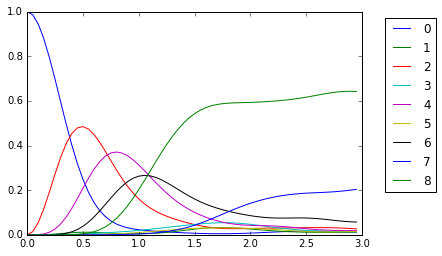

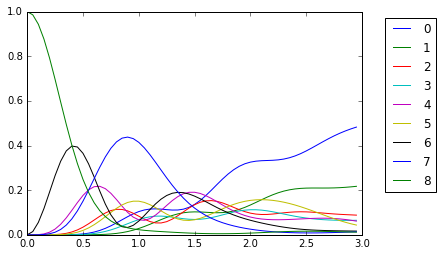

In [8]:
end = (int) (n*3)

for i in range(L):
    plt.plot(np.arange(end)/n,weightfore9[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylim(0,1)
plt.show()

for i in range(L):
    plt.plot(np.arange(end)/n,weightback9[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylim(0,1)
plt.show()

# Time Usage
### For L=9

In [29]:
# with @ operator
%run -t timeHamiltonian.py


IPython CPU timings (estimated):
  User   :      29.43 s.
  System :       1.20 s.
Wall time:      15.51 s.


In [5]:
# with np.matmul
%run -t timeHamiltonian.py


IPython CPU timings (estimated):
  User   :      27.76 s.
  System :       1.08 s.
Wall time:      14.48 s.


In [35]:
# with np.matmul, inv->mult
%run -t timeHamiltonian.py


IPython CPU timings (estimated):
  User   :      25.35 s.
  System :       1.09 s.
Wall time:      13.43 s.


In [8]:
# with np.matmul, n = 60, end = 1
%run -t timeHamiltonian.py


IPython CPU timings (estimated):
  User   :      27.96 s.
  System :       1.08 s.
Wall time:      14.58 s.


In [39]:
# with np.dot
%run -t timeHamiltonian.py


IPython CPU timings (estimated):
  User   :      28.58 s.
  System :       1.11 s.
Wall time:      14.99 s.


In [48]:
# with expm
%run -t timeHamiltonian.py


IPython CPU timings (estimated):
  User   :      56.23 s.
  System :       4.50 s.
Wall time:      30.46 s.


In [75]:
%run -p timeHamiltonian.py

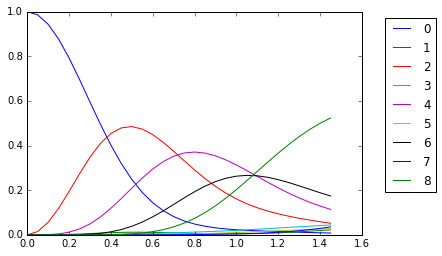

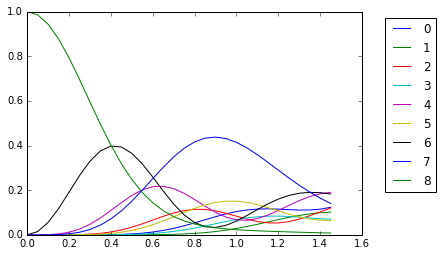

In [43]:
end = (int) (n*1.5)

for i in range(L):
    plt.plot(np.arange(end)/n,weightfore9[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

for i in range(L):
    plt.plot(np.arange(end)/n,weightback9[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

### For L=11

In [15]:
# with np.matmul
%run -t timeHamiltonian11.py


IPython CPU timings (estimated):
  User   :      46.33 s.
  System :       1.83 s.
Wall time:      32.22 s.


In [17]:
# with np.matmul, inv->mult
%run -t timeHamiltonian11.py


IPython CPU timings (estimated):
  User   :      40.96 s.
  System :       1.25 s.
Wall time:      26.10 s.


In [18]:
%run -p timeHamiltonian11.py

### Now with block diag list

In [80]:
# with block diag list
%run -t timeHamiltonianlist.py


IPython CPU timings (estimated):
  User   :      15.25 s.
  System :       1.13 s.
Wall time:       8.24 s.


In [27]:
# with Alist as arrays
%run -t timeHamiltonianlist.py


IPython CPU timings (estimated):
  User   :      15.00 s.
  System :       1.15 s.
Wall time:       8.24 s.


In [9]:
# Without superfluous norm
%run -t timeHamiltonianlist.py


IPython CPU timings (estimated):
  User   :      10.46 s.
  System :       0.97 s.
Wall time:       5.84 s.


In [81]:
%run -p timeHamiltonianlist.py

### L=11 block diag

In [32]:
%run -t timeHamiltonian11list.py
#          27778 function calls (27773 primitive calls) in 15.123 seconds

#    ncalls  tottime  percall  cumtime  percall filename:lineno(function)
#         1    7.388    7.388    7.415    7.415 decomp.py:202(eigh)
#        74    5.385    0.073    5.385    0.073 {built-in method numpy.core.multiarray.matmul}
#         4    0.719    0.180    0.731    0.183 hamiltonian.py:96(mat2list)
#         2    0.465    0.232    0.504    0.252 hamiltonian.py:110(list2mat)


IPython CPU timings (estimated):
  User   :      25.96 s.
  System :       1.39 s.
Wall time:      17.55 s.


In [33]:
# with Alist as arrays
%run -t timeHamiltonian11fulllist.py
#          27756 function calls (27751 primitive calls) in 13.425 seconds

#    ncalls  tottime  percall  cumtime  percall filename:lineno(function)
#         1    6.738    6.738    6.771    6.771 decomp.py:202(eigh)
#        50    4.865    0.097    4.865    0.097 {built-in method numpy.core.multiarray.matmul}
#         2    0.436    0.218    0.562    0.281 hamiltonian.py:110(list2mat)
#         2    0.322    0.161    0.327    0.164 hamiltonian.py:96(mat2list)


IPython CPU timings (estimated):
  User   :      24.28 s.
  System :       1.12 s.
Wall time:      15.68 s.


In [10]:
# Without superfluous norm
%run -t timeHamiltonian11fulllist.py

#          27654 function calls (27649 primitive calls) in 12.047 seconds

#    ncalls  tottime  percall  cumtime  percall filename:lineno(function)
#         1    7.154    7.154    7.182    7.182 decomp.py:202(eigh)
#        48    2.890    0.060    2.890    0.060 {built-in method numpy.core.multiarray.matmul}
#         2    0.534    0.267    0.588    0.294 hamiltonian.py:110(list2mat)
#         2    0.451    0.225    0.456    0.228 hamiltonian.py:96(mat2list)


IPython CPU timings (estimated):
  User   :      17.77 s.
  System :       0.94 s.
Wall time:      11.34 s.


In [11]:
%run -p timeHamiltonian11fulllist.py

[]

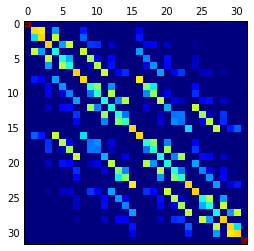

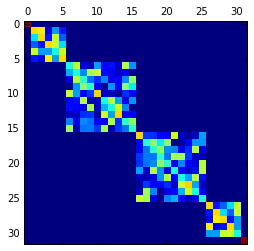

In [28]:
L = 5
alph2Sz, Sz2alph = hm.permutations(L)
H = hm.sparse_H(L)
vals, vecs = la.eigh(H)
eners = np.diag(vals)
vecsd = vecs.T.conj()
t = .5
unitt = np.matmul(vecs * np.exp(-1j*vals*t), vecsd)
# unitt = np.matmul(vecs * vals, vecsd)
uninv = np.matmul(vecs * np.exp( 1j*vals*t), vecsd)
plt.matshow(np.absolute(unitt))
plt.plot()
# print(np.shape(unitt))
udiag = unitt[alph2Sz]
# print(np.shape(udiag))
udiag = udiag[:,alph2Sz]
# plt.matshow(np.absolute(udiag))
plt.matshow(np.absolute(udiag))
# plt.colorbar()
plt.plot()

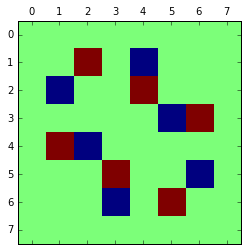

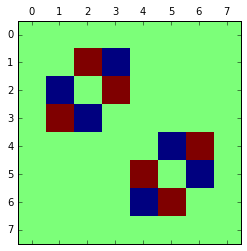

In [20]:
L = 3
H = hm.sparse_H(L)

alph2Sz, Sz2alph = hm.permutations(L)

plt.matshow(np.imag(H))
plt.show()
Hdiag = H[alph2Sz]
Hdiag = Hdiag[:,alph2Sz]
plt.matshow(np.imag(Hdiag))
plt.show()

In [10]:
L = 4
A = hm.Z
for i in range(L-1):
    A = np.kron(A,hm.I)
print(A)
Alist = hm.mat2list(A)

[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]]


In [9]:
for M in Alist: print(M)

[[1]]
[[ 1  0  0  0]
 [ 0  1  0  0]
 [ 0  0  1  0]
 [ 0  0  0 -1]]
[[ 1  0  0  0  0  0]
 [ 0  1  0  0  0  0]
 [ 0  0  1  0  0  0]
 [ 0  0  0 -1  0  0]
 [ 0  0  0  0 -1  0]
 [ 0  0  0  0  0 -1]]
[[ 1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0 -1  0]
 [ 0  0  0 -1]]
[[-1]]


In [16]:
alph2Sz, Sz2alph = hm.permutations(L)
A = np.array([hm.Z[0,0], hm.Z[1,1]])
for i in range(L-1):
    A = np.kron(A,np.array([1,1]))
hm.arr2list(A)

[array([1]),
 array([ 1,  1,  1, -1]),
 array([ 1,  1,  1, -1, -1, -1]),
 array([ 1, -1, -1, -1]),
 array([-1])]

In [3]:
string = "hello world"
print("this " + string.replace("rld", ""))

this hello wo


In [ ]:
print"hello"